In [ ]:
# "Visualizing atomic type orbitals in molecules"
> "How to compute and visualize natural atomic orbitals with PySCF"

toc: true
badges: true
comments: true
categories: [quantum chemistry]

## Introduction 

Sometimes we need to display atomic type orbitals in a schematic way to visualize simple concepts. The molecular orbitals or even localized orbitals are then overly complex. Simple examples are the ChemDraw-style orbitals, which are used to rationalize reactions in organic chemistry. Now, is it possible to obtain similar orbitals, but in 3D?

## Computing the 3D structure

We will use benzene as an example. First we generate the 3D coordinates using RDKit

In [22]:
from rdkit import Chem
from rdkit.Chem import AllChem

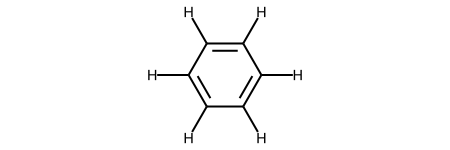

In [23]:
smiles = "c1ccccc1"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
mol

In [24]:
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)

0

We visualize the structure using py3Dmol

In [25]:
import py3Dmol

In [26]:
v = py3Dmol.view()
v.addModel(Chem.MolToMolBlock(mol), 'mol')
v.setStyle({'stick':{}})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Calculating the NAOs

We will now use PySCF to calculate the NAOs. As we are only interested in the schematic form of the orbitals, the small STO-3G basis set will be sufficient. First we construct the PySCF Mole object from the RDKit Mol object.

In [27]:
import pyscf
from pyscf import gto, lo, tools, dft 

In [28]:
elements = [atom.GetSymbol() for atom in mol.GetAtoms()]
coordinates = mol.GetConformer().GetPositions()
atoms = [(element, coordinate) for element, coordinate in zip(elements, coordinates)]

pyscf_mole = gto.Mole(basis="sto-3g")
pyscf_mole.atom = atoms
pyscf_mole.build()

We then run the DFT calculation, which is actually quite fast

In [29]:
mf = dft.RKS(pyscf_mole)
mf.xc = 'b3lyp'
mf.run()

converged SCF energy = -229.25142113646


We can now compute the NAOs from the 1-st order reduced density matrix. Note that we are here actually calculating the pre-orthogonal NAOs (PNAOs) that are even more local that the NAOs. We the write the PNAOs to cube files - these files can be quite large, ca 7 MB each.

In [30]:
dm = mf.make_rdm1()
naos = lo.nao.prenao(pyscf_mole, dm)

In [31]:
for i in range(naos.shape[1]):
    tools.cubegen.orbital(pyscf_mole, 'benzene_nao_{:02d}.cube'.format(i+1), naos[:,i])

## Visualizing the NAOs

Here we use py3Dmol and ipywidgets to interactively view the orbitals. If you are viewing a static rending of this page, the interactive mode will not work, so you will need to open it on Binder or run it locally on your own machine.

In [32]:
from ipywidgets import interact

In [33]:
def draw_orbital(view, i):
    with open(f"./benzene_nao_{i:02d}.cube") as f:
        cube_data = f.read()
    view.addVolumetricData(cube_data, "cube", {'isoval': -0.04, 'color': "red", 'opacity': 0.75})
    view.addVolumetricData(cube_data, "cube", {'isoval': 0.04, 'color': "blue", 'opacity': 0.75})
    view.addModel(Chem.MolToMolBlock(mol), 'mol')
    view.setStyle({'stick':{}})
    view.zoomTo()
    view.update()
    view.clear()

In [34]:
from ipywidgets import fixed, interact_manual, interactive

In [35]:
n_orbitals = naos.shape[1]
view = py3Dmol.view(width=400,height=400)
view.show()
interact_manual(draw_orbital, view=fixed(view), i=(1, n_orbitals));

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

interactive(children=(IntSlider(value=18, description='i', max=36, min=1), Button(description='Run Interact', …

## Acknowledgements

iwatobipen's [blog post](https://iwatobipen.wordpress.com/2020/03/07/rendering-molecular-orbital-on-jupyter-notebook-psikit-py3dmol-rdkit-memo/) on the rendering of orbitals with py3Dmol was very helpful when writing this notebook.

## Licensing and citation

Code free to use under an [MIT license](https://opensource.org/licenses/MIT).

For citation, use webpage address and access date.